# Evaluating the Sentiment of Influential Texts 

Sacred texts have been painstakingly studied by scholars for thousands of years.  These texts provide valuable insights into the hearts and minds of their authors and practitioners.  

This project is my attempt to answer the question:

Are the practitioners of certain religions more likely to have a positive outlook on life than the practitioners others?  

The code below uses computational techniques to compare the overall sentiment of some of the most influential texts in recorded history.


In [1]:
import re
import spacy
import string
import math
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from string import punctuation
from collections import Counter
nltk.download('wordnet')
nltk.download('punkt') 
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.display import Image, display

# plot set up
mpl.rc('savefig', dpi=200)
plt.style.use('fivethirtyeight')
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 1
sns.set(style = "whitegrid", color_codes = True, font_scale = 1.5)


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathewbuck/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathewbuck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data and Text Files  

I was able to find most of my data at the Gutenburg Project, but I had to dig a little deeper for some of the documents.


Information on all of the sources and translations can be found at the beginning of each individual text file.  


In [2]:
text_df_path = "text_df.csv"
most_common_df_path = "most_common_df.csv"

darth_path = "darth.jpg"
vader_lex_path = "vader_lexicon.txt"
new_testament_path = "new_testament.txt"
mein_kampf_path = "mk.txt"
quran_path = "quran.txt"
book_of_dead_path = "book_of_dead.txt"
tao_te_ching_path = "tao_te_ching.txt"
buddhist_sutras_path = "buddhist_sutras.txt"
bhagavad_gita_path = "bhagavad_gita.txt"
torah_path = "torah.txt"
hate_speech_path = "hate_speech.txt"
yoga_sutras_path ="yoga_sutras.txt"

new_testament = open(new_testament_path, encoding="utf-8").read()
torah = open(torah_path, encoding="utf-8").read()
mein_kampf = open(mein_kampf_path, encoding="utf-8").read()
quran = open(quran_path, encoding = "utf-8").read()
book_of_dead = open(book_of_dead_path, encoding="utf-8").read()
tao_te_ching = open(tao_te_ching_path, encoding="utf-8").read()
buddhist_sutras = open(buddhist_sutras_path, encoding="utf-8").read()
bhagavad_gita = open(bhagavad_gita_path, encoding="utf-8").read()
hate_speech = open(hate_speech_path, encoding="utf-8").read()
yoga_sutras = open(yoga_sutras_path, encoding="utf-8").read()

print("The type of the raw text is:", type(new_testament))
print()

print("Load raw data into a DataFrame object.")

texts = ([["Tao Te Ching", -600, tao_te_ching], 
          ["Book of Dead", -1550, book_of_dead], 
          ["Torah", -600, torah],
          ["Buddhist Sutras", -200, buddhist_sutras],
          ["Quran", 650, quran], 
          ["Bhagavad Gita",-500, bhagavad_gita],
          ["New Testament", 140, new_testament],
          ["Mein Kampf", 1925, mein_kampf],
          ["Yoga Sutras", 400, yoga_sutras],
          ["Hate Speech", 2019, hate_speech]])
         
text_df = pd.DataFrame(texts, columns=["title", "approx_date", "raw_text"])
text_df

The type of the raw text is: <class 'str'>

Load raw data into a DataFrame object.


,title,approx_date,raw_text
0,Tao Te Ching,-600,Chapter One\nTao Te Ching\nTao (The Way) that ...
1,Book of Dead,-1550,Papyrus of Ani\nEgyptian Book of the Dead\nTHE...
2,Torah,-600,Book 01 Genesis\n\n01:001:001 In the be...
3,Buddhist Sutras,-200,"\n\nI, Ánanda, Live in the Fullness of Emptin..."
4,Quran,650,"﻿In the name of Allah, most benevolent, ever-m..."
5,Bhagavad Gita,-500,BHAGAVAD GITA\n\nGITA MAHATMYA GLORY OF THE GI...
6,New Testament,140,The New Testament A Faithful Translation\nCopy...
7,Mein Kampf,1925,\nHate hate hate hate hate hate hate hate hate...
8,Yoga Sutras,400,THE YOGA SUTRAS OF PATANJALI\n\nBOOK 1\n1. OM:...
9,Hate Speech,2019,"HATE SPEECH\n\n""You forgot to mention just how..."


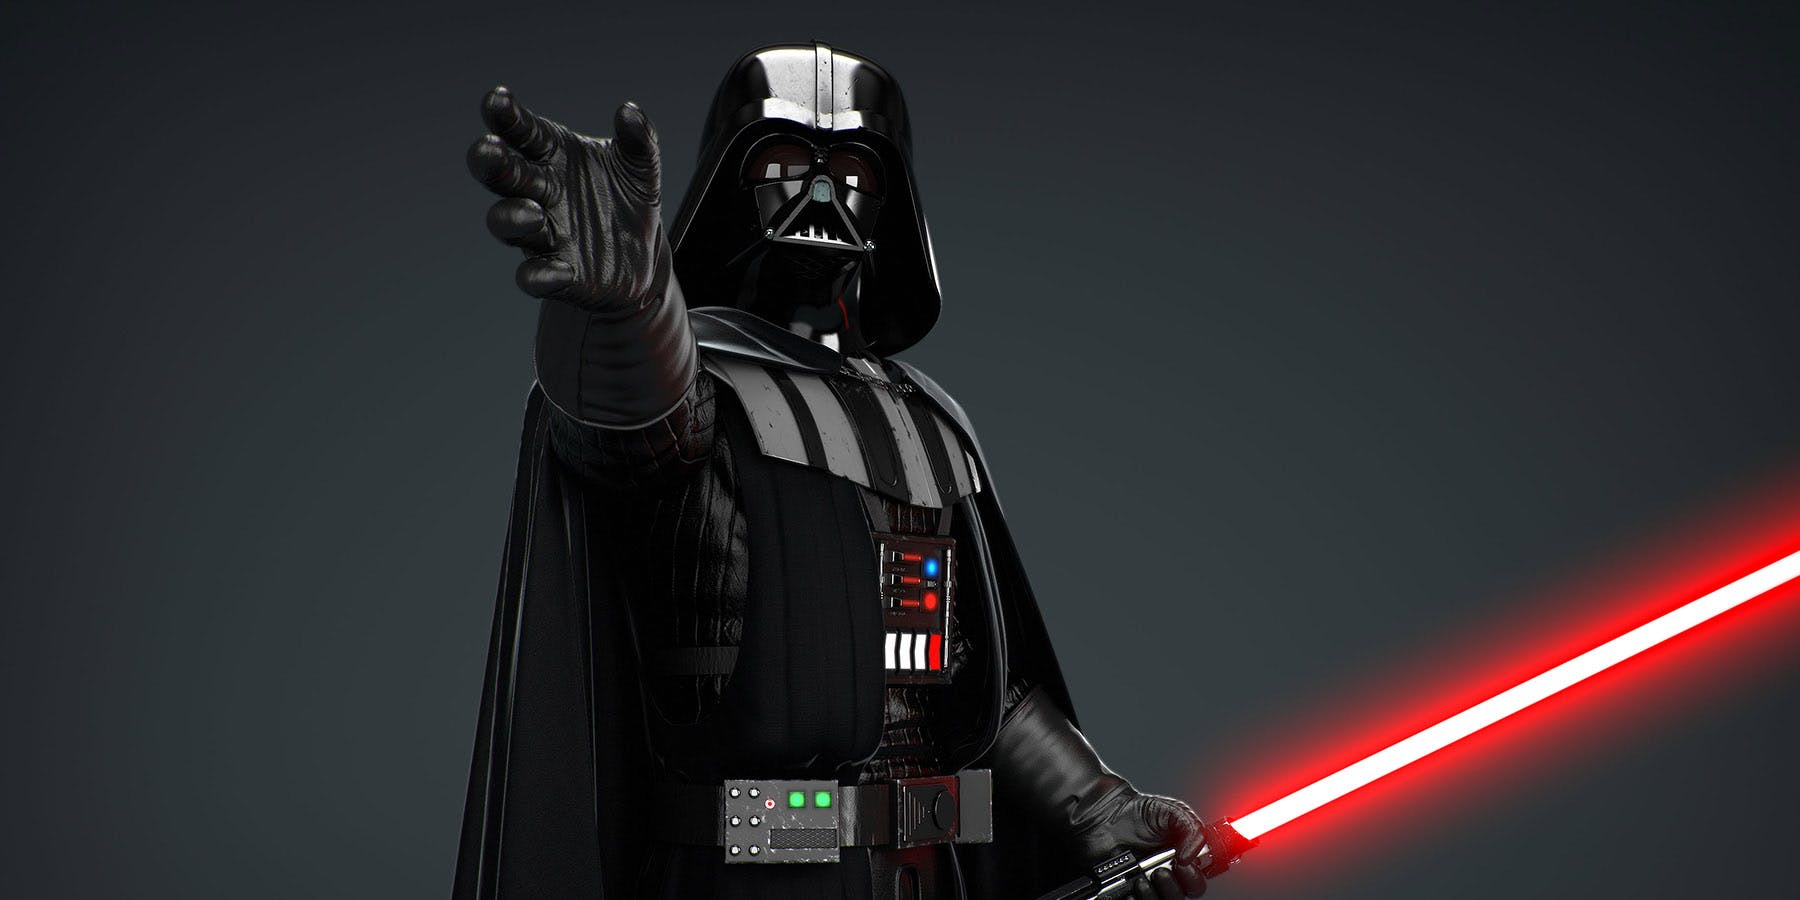

In [3]:
display(Image(darth_path, width=600, unconfined=True))

## Vader Sentiment Analysis

I built my sentiment analysis tool using the VADER lexicon (Valence Aware Dictionary for Entiment Reasoning). 

The text file can be found here: %%html
<a href="https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt
">"VADER lexicon textfile"</a>

More info on VADER can be found here: %%html
<a href="http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html">"VADER Tutorial"</a>

In [4]:
vader_lex_df = pd.read_csv('vader_lexicon.txt', sep="\t", header=None) 
vader_lex_df.columns = ['word', 'polarity', 'junk', 'trash']
vader_lex_df = vader_lex_df.drop(['junk', 'trash'], axis=1)
#vader_lex_df.iloc[2000 : 2005]

print("VADAR thinks that there are around 7,000 words that can help quantify the sentiment of a sentence.")
vader_lex_df.describe()


VADAR thinks that there are around 7,000 words that can help quantify the sentiment of a sentence.


,polarity
count,7517.000000
mean,-0.179580
std,1.702407
min,-3.900000
25%,-1.600000
50%,-0.500000
75%,1.500000
max,3.400000


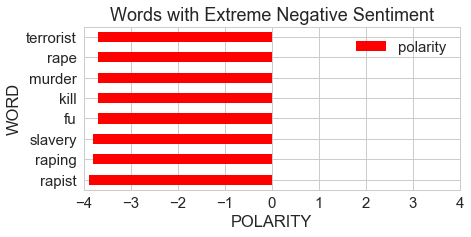

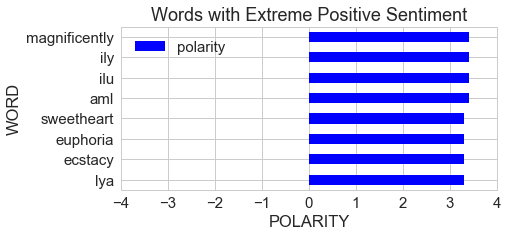

In [5]:
extreme_neg = (vader_lex_df[vader_lex_df['polarity']
                .agg(lambda x: (x <= -3.7))]
                .sort_values('polarity')
                .set_index("word"))

extreme_pos = (vader_lex_df[vader_lex_df['polarity']
                .agg(lambda x: (x >= 3.3))]
                .sort_values('polarity')
                .set_index("word"))

fig = extreme_neg.plot.barh(figsize=(6, 3), color = "red")
plt.xlim([-4, 4])
plt.xlabel("POLARITY")
plt.ylabel("WORD")
plt.title("Words with Extreme Negative Sentiment");
print()

fig = extreme_pos.plot.barh(figsize=(6, 3), color = "blue")
plt.xlim([-4, 4])
plt.xlabel("POLARITY")
plt.ylabel("WORD")
plt.title("Words with Extreme Positive Sentiment");


## The Algorithms

I built my sentiment analysis tool to accurately compare text files of varying lengths ranging from a single sentence to thousands of pages.  

The algorithm works by breaking a text file down into sentences, evaluating the sentiment of each sentence independently, then returning the mean sentence sentiment for the text file. That way the overall length of the text doesn't effect the outcome. 

In [6]:
analyser = SentimentIntensityAnalyzer()
    

def avg_sentiment_rating(raw_text_str):
    """paramater: string representing either a single or many sentences
       return: an int representing the average sentiment rating
       of all the sentences contained in the entire text file"""
    return (pd.Series(sent_tokenize(raw_text_str))
                    .apply(sentence_sentiment_score)
                    .mean())


def most_polarized_sentence(raw_text_str, negative=False):
    """paramater: raw_text_str is a string representing either a single or many sentences,
       parameter: negative is a boolean
       return (negative=False): string which is the most positve sentence in the entire text file
       return (negative=True): string which is the most negative sentence in the text file"""
    sentences_ser = pd.Series(sent_tokenize(raw_text_str))
    sentiment_ratings = sentences_ser.apply(sentence_sentiment_score)
    zipped = list(zip(sentiment_ratings.index, sentiment_ratings))
    if negative:
        most_pos_tup = min(zipped, key=lambda x: x[1])
    else:
        most_pos_tup = max(zipped, key=lambda x: x[1])
    most_pos_sent = sentences_ser[most_pos_tup[0]]
    return most_pos_sent.replace("\n", " ");


# helper function
def sentence_sentiment_score(sentence_str):
    """parameter: string representing a single sentence
       return: the sentiment rating of sentence_str"""
    #print("{:-<40} {}".format(sentence, str(snt)))
    return analyser.polarity_scores(sentence_str)["compound"]
    

## Sentiment Analysis

In [7]:
#%%time
#This cell calculates sentiment_ratings in around 20 seconds then adds the sentiment_ratings
#to the existing DataFrame object text_df.

raw_text_ser = text_df["raw_text"]
sentiment_ratings = raw_text_ser.apply(avg_sentiment_rating)
text_df["sentiment_rating"] = sentiment_ratings
print("Add sentiment ratings to the DataFrame.")
text_df


Add sentiment ratings to the DataFrame.


,title,approx_date,raw_text,sentiment_rating
0,Tao Te Ching,-600,Chapter One\nTao Te Ching\nTao (The Way) that ...,0.198803
1,Book of Dead,-1550,Papyrus of Ani\nEgyptian Book of the Dead\nTHE...,0.140289
2,Torah,-600,Book 01 Genesis\n\n01:001:001 In the be...,0.028977
3,Buddhist Sutras,-200,"\n\nI, Ánanda, Live in the Fullness of Emptin...",0.098136
4,Quran,650,"﻿In the name of Allah, most benevolent, ever-m...",0.102195
5,Bhagavad Gita,-500,BHAGAVAD GITA\n\nGITA MAHATMYA GLORY OF THE GI...,0.106659
6,New Testament,140,The New Testament A Faithful Translation\nCopy...,0.092208
7,Mein Kampf,1925,\nHate hate hate hate hate hate hate hate hate...,0.047244
8,Yoga Sutras,400,THE YOGA SUTRAS OF PATANJALI\n\nBOOK 1\n1. OM:...,0.165009
9,Hate Speech,2019,"HATE SPEECH\n\n""You forgot to mention just how...",-0.137959


In [8]:
# This cell saves the DataFrame object I created above to text_df.csv. 
#This is just to speed up processing during presentation.
#text_df.to_csv("text_df.csv", sep=',', encoding='utf-8', index=False)  # new csv file goes to proj file. 


In [9]:
# This cell reads in the text_df.csv file I created earlier to speed up processing.
#text_df = pd.read_csv(text_df_path)
#print("Add sentiment ratings to the DataFrame.")
#text_df


## Most Polarized Sentence in a given text. 

In [10]:
titles = text_df["title"]
raw_texts = text_df["raw_text"]

print("The most positive sentences in the first couple texts are:")
print()
for i in range(2):
    print(titles[i])
    print(most_polarized_sentence(raw_texts[i]))
    print()

print()
print()
print("The most negative sentences in the first few texts are:")
print()
for i in [2, 4]:
    print(titles[i])
    print(most_polarized_sentence(raw_texts[i], negative=True))
    print()
    

The most positive sentences in the first couple texts are:

Tao Te Ching
Chapter Thirty-nine In the beginning, there were those who attained the Oneness; Heaven, by attaining the Oneness became clear; Earth, by attaining the Oneness became peaceful; Spirit, by attaining the Oneness became divine; True nature is like an empty valley, and by attaining the Oneness, It became fully productive.

Book of Dead
HERE BEGIN THE PRAISES AND GLORIFYINGS OF COMING OUT FROM AND OF GOING INTO THE GLORIOUS KHERT-NETER, WHICH IS IN THE BEAUTIFUL AMENTET, OF COMING FORTH BY DAY IN ALL THE FORMS OF EXISTENCE WHICH IT MAY PLEASE THE DECEASED TO TAKE, OF PLAYING AT DRAUGHTS, OF SITTING IN THE SEH HALL, AND OF APPEARING AS A LIVING SOUL: The Osiris the scribe Ani saith after he hath arrived in his haven of rest- now it is good for [a man] to recite [this work whilst he is] upon earth, for then all the words of Tem come to pass- "I am the god Tem in rising.



The most negative sentences in the first few tex

## Text Processing Pipeline

In [11]:
punct_re = r'[^\w\s]'  # regex to remove punctuation
regex = re.compile(punct_re)
stop_words_lst = stopwords.words("english")
stemmer = PorterStemmer()


def most_common_words(text_str, N=10):
    """paramater: string of text
       return: list of tuples ("word", count)
       for the 10 most common words in raw_text"""
    clean_str = clean_by_word(text_str)
    return Counter(clean_str).most_common(N)  


# tokenize by word  
def clean_by_word(text_str):
    """parameter: string of text
       return: pandas Series of cleaned words
       function: splits on each word,
                 changes chars to lower, and words to stems
                 removes stop words and punctuation"""
    result = regex.sub(' ', text_str).lower()  # remove punc
    result = word_tokenize(result)  # break into list of words
    result = no_stops(result)  
    return stems(result) 
    

def stems(words_lst):
    """parameter: list of words
       return: list of stem words"""
    return pd.Series(words_lst).apply(stemmer.stem)


def no_stops(words_lst):
    """paramater: list of words
       return:  list of words with the stop words removed"""
    return [word for word in words_lst if word not in stop_words_lst]


# Statistics on the Sentiment Ratings

In [12]:
print("Sentiment Rating Statistics")
text_df["sentiment_rating"].describe()


Sentiment Rating Statistics


count    10.000000
mean      0.084156
std       0.092896
min      -0.137959
25%       0.058485
50%       0.100165
75%       0.131882
max       0.198803
Name: sentiment_rating, dtype: float64

/Users/mathewbuck/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/mathewbuck/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


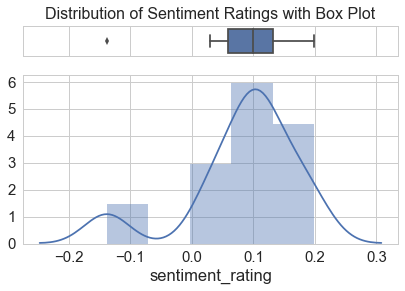

In [13]:
# Cut the window in 2 parts
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

# Add a graph in each part
fig = sns.boxplot(text_df["sentiment_rating"], ax=ax_box)
fig = sns.distplot(text_df["sentiment_rating"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

# Change figure size
fig = sns.set(rc={'figure.figsize':(11.7, 8.27)}) 

# Move title up on y axis
plt.title("Distribution of Sentiment Ratings with Box Plot", y=1.3, fontsize = 16);

## Most Common Words

In [14]:
#%%time

titles_ser = text_df["title"]
raw_texts_ser = text_df["raw_text"]

most_common_df = pd.DataFrame()
i = 0 
for title in titles_ser:
    most_common_df[title] = most_common_words(raw_texts_ser[i])
    i += 1
    

In [15]:
# This cell saves the DataFrame object I created above to text_df.csv. 
#This is just to speed up processing during presentation.
#most_common_df.to_csv("most_common_df.csv", sep=',', encoding='utf-8', index=False)  # new csv file goes to proj file. 


In [16]:
# This cell reads in the text_df.csv file I created earlier to speed up processing.
#most_common_df = pd.read_csv(most_common_df_path)


In [17]:
print("The 10 most common words in each text.")
most_common_df


The 10 most common words in each text.


,Tao Te Ching,Book of Dead,Torah,Buddhist Sutras,Quran,Bhagavad Gita,New Testament,Mein Kampf,Yoga Sutras,Hate Speech
0,"(one, 202)","(god, 530)","(shall, 2828)","(one, 845)","(god, 2954)","(arjuna, 278)","(zoe, 1737)","(peopl, 1121)","(spiritu, 359)","(go, 10)"
1,"(tao, 138)","(osiri, 514)","(unto, 2356)","(bhikkhu, 399)","(lord, 1004)","(action, 239)","(one, 1718)","(nation, 1108)","(man, 273)","(white, 10)"
2,"(natur, 113)","(thou, 510)","(lord, 1890)","(bless, 394)","(believ, 739)","(yoga, 207)","(god, 1701)","(german, 965)","(power, 222)","(black, 9)"
3,"(chapter, 81)","(shall, 445)","(01, 1534)","(monk, 376)","(say, 715)","(one, 204)","(say, 1366)","(state, 909)","(life, 183)","(jew, 5)"
4,"(peopl, 80)","(thi, 345)","(thou, 1524)","(mind, 350)","(said, 655)","(cha, 190)","(jesu, 1354)","(would, 899)","(mind, 163)","(kill, 5)"
5,"(great, 66)","(word, 318)","(04, 1289)","(thu, 328)","(peopl, 542)","(lord, 186)","(life, 1317)","(one, 824)","(conscious, 159)","(trump, 5)"
6,"(shall, 61)","(thee, 300)","(thi, 1253)","(would, 316)","(come, 531)","(self, 179)","(16, 961)","(time, 697)","(come, 147)","(want, 5)"
7,"(true, 59)","(truth, 266)","(02, 1214)","(vener, 257)","(day, 503)","(na, 168)","(also, 925)","(must, 690)","(psychic, 142)","(peopl, 4)"
8,"(world, 48)","(forth, 264)","(05, 960)","(gotama, 248)","(one, 478)","(mind, 151)","(come, 916)","(even, 606)","(one, 141)","(women, 4)"
9,"(know, 45)","(whose, 248)","(thee, 959)","(said, 228)","(know, 465)","(thou, 131)","(said, 869)","(could, 557)","(self, 129)","(year, 4)"


# Visualize the Results of my Sentiment Analysis
I added pure hate speech data to give a viewer a reference point.


I used a collection of pure hate speech as a test for negativity.


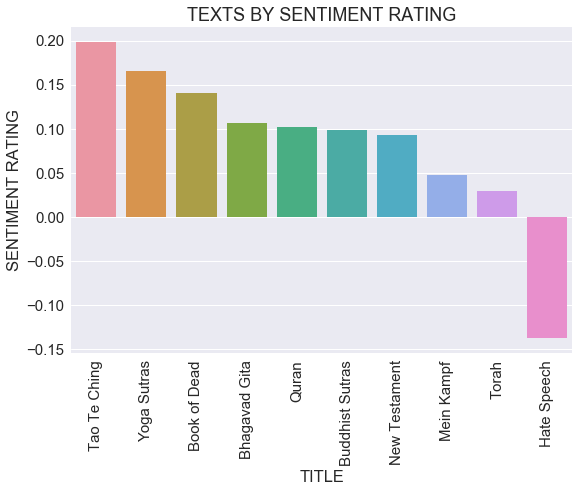

In [18]:
print()
print("I used a collection of pure hate speech as a test for negativity.")
text_df = text_df.sort_values(by="sentiment_rating", ascending=False)    
sns.set(font_scale=1.5)
fig = plt.figure(figsize=(8, 6))
fig = sns.barplot(x="title", y='sentiment_rating', data=text_df)
fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
plt.xlabel("TITLE")
plt.ylabel("SENTIMENT RATING")
plt.title("TEXTS BY SENTIMENT RATING");


In [19]:
print("The DataFrame has been sorted in ascending order by approximate date written.")
text_df = text_df[text_df["title"] != "Mein Kampf"]
text_df = (text_df[text_df["title"] != "Hate Speech"]
                   .sort_values("approx_date"))

#text_df


The DataFrame has been sorted in ascending order by approximate date written.


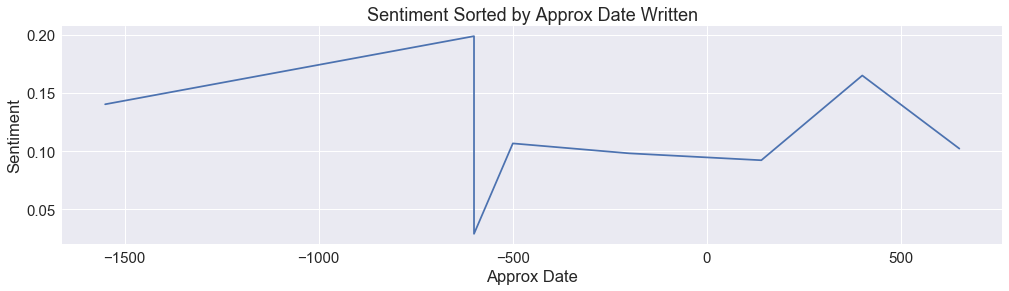

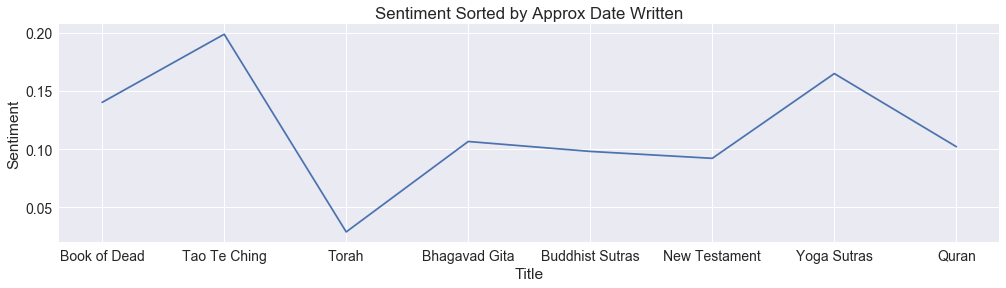

In [20]:
sns.set() # plot the Seaborn version

sns.set(font_scale=1.5)
plt.figure(figsize=(15, 4))
plt.plot(text_df["approx_date"], text_df["sentiment_rating"])
plt.title("Sentiment Sorted by Approx Date Written")
plt.xlabel("Approx Date")
plt.ylabel("Sentiment");
print()

sns.set(font_scale=1.4)
fig = plt.figure(figsize=(15, 4))
fig = plt.plot(text_df["title"], text_df["sentiment_rating"])
plt.title("Sentiment Sorted by Approx Date Written")
plt.xlabel("Title")
plt.ylabel("Sentiment");


# Conclusion

The good news is that if God actually inspired any of these texts, we can clearly see his or her good days ;) 

The low rating for the Torah seems to make sense since a lot of it was written during the Babylonian Captivity. 

The take away from this project is that if you want to learn about people, study these texts.
If you want to learn about God, study mathematics and physics.  


I found extreme differences in sentiment among the texts.

I learned that there are many subtle little tricks that can make data cleaning and pandas programing much more efficient. 

If I had unlimited time and money I would try to translate some of the cuneiform tablet stockpile with image classification machine learning. 

In the future I may try to scrape a random sample of tweets and test their sentiment against these texts. It would be interesting to see the results.
